# Xarray

## Goal
- In xarray you can easily create and write CF compliant netCDF files
- We will show the procedure by means of 2 examples

### Overview

* xarray is for __N-dimensional arrays__

* for geoscientists who need to use __netCDF__.

* attaches __Dimensions__ indexes and __Coordinate__ names to numpy’s ndarray

Source of this introduction: [Xarray Documentation](http://xarray.pydata.org/en/stable/index.html).

___
### Getting started

In [2]:
# Import standard packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Xarray is conventionally imported as 'xr'
import xarray as xr
from datetime import timedelta, datetime
from cftime import date2num
from pyproj import Proj
import cartopy as cp
import cartopy.crs as ccrs

___
### Core data structures <a name="data_structures"></a>

Xarray provides two core data structures:

* __DataArray__ is a __labeled, N-dimensional array__ (similar to _pandas.Series_)
    
* __Dataset__ is a multi-dimensional, __container of DataArray__ objects with shared dimensions (similar to _pandas.DataFrame_)

#### Dataset

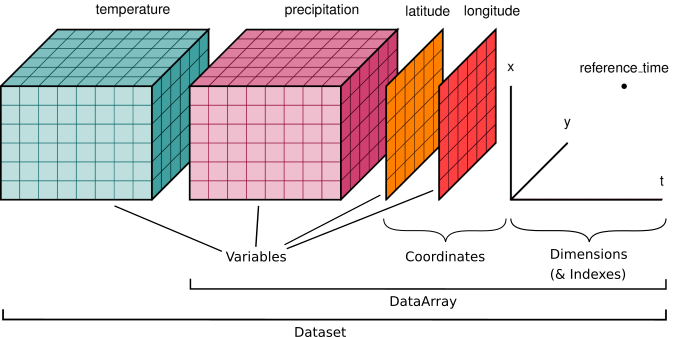

In [2]:
from IPython.display import Image
Image("https://docs.xarray.dev/en/stable/_images/dataset-diagram.png")

Datasets have four key properties:

* `dims`: a dictionary mapping from dimension names to the fixed length of each dimension (e.g., `{'x': 6, 'y': 6, 'time': 8}`)
* `data_vars`: a multi-dimensional array of values (e.g., a Numpy ndarray, DataFrame) 
* `coords`: container of arrays intended to label points used in `data_vars` (e.g., arrays of positional numbers, datetime objects or strings)
* `attrs`: a dictionary to hold arbitrary metadata

## Procedure to create netCDF files by means of xarray
- create **Coordinate Variables**
- create **Data Variables**
- create a **Dataset object** in xarray containing dimensions, coordinates and data variables
- add **metadata** as attributes to the Dataset object
- use Dataset.to_netcdf() to **write the Dataset to a netCDF file**

We will show how this works in 2 examples:
1. Gridded Data on a curvilinear grid
2. Multiple Time Series: time dimension has the same number of elements and the time values are identical for all instances

## 1. Gridded data on a curvilinear grid
In our example we assume:
- random air temperature data on different pressure levels
- NorthPolarStereograpic projection

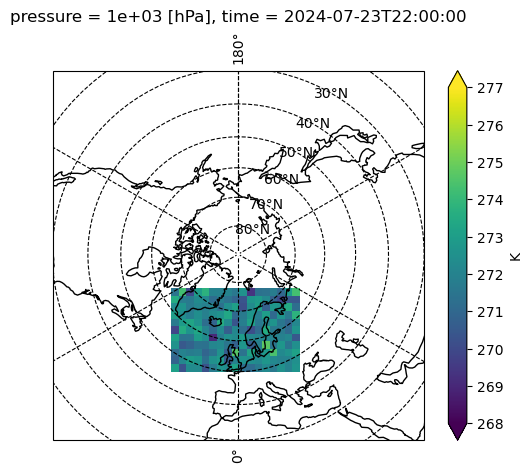

In [3]:
dsplot = xr.open_dataset("grid_data_example.nc")
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude=90))
ax.set_extent([0, 360, 30, 90], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(color='k', linestyle='dashed', draw_labels=True)
dsplot["x"]=dsplot.x*1000
dsplot["y"]=dsplot.y*1000
p = dsplot.Temperature[0,0,:,:].plot.pcolormesh(ax=ax, vmin=268,vmax=277, add_colorbar=False, 
                                   transform=ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude=90))
cbar = plt.colorbar(p, orientation='vertical', label='K', extend='both')

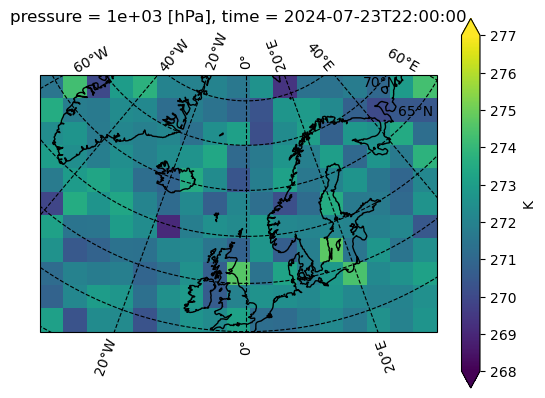

In [4]:
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude=90))
ax.coastlines()
ax.gridlines(color='k', linestyle='dashed', draw_labels=True)
p = dsplot.Temperature[0,0,:,:].plot.pcolormesh(ax=ax, vmin=268,vmax=277, add_colorbar=False, 
                                   transform=ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude=90))
cbar = plt.colorbar(p, orientation='vertical', label='K', extend='both')

#### Create Coordinate Variables
we create the content of x, y, press, time as coordinate variables:

In [37]:
# 300-km spacing in x and y
x = np.arange(-2500, 2500, 300)
y = np.arange(-4500, -1200, 300)
# Make coordinate variable of pressure levels in hPa
press = np.array([1000, 925, 850, 700, 500, 300, 250])

# Set start time to 22 o'clock of today's date
start = datetime.now().replace(hour=22, minute=0, second=0, microsecond=0)
# Make coordinate variable of time
times = np.array([start + timedelta(hours=h) for h in range(13)])
print(times)
time_units = f'hours since {times[0]:%Y-%m-%d 00:00}'
print(time_units)
time_vals = date2num(times, time_units)
print(time_vals)

[datetime.datetime(2024, 7, 23, 22, 0)
 datetime.datetime(2024, 7, 23, 23, 0)
 datetime.datetime(2024, 7, 24, 0, 0) datetime.datetime(2024, 7, 24, 1, 0)
 datetime.datetime(2024, 7, 24, 2, 0) datetime.datetime(2024, 7, 24, 3, 0)
 datetime.datetime(2024, 7, 24, 4, 0) datetime.datetime(2024, 7, 24, 5, 0)
 datetime.datetime(2024, 7, 24, 6, 0) datetime.datetime(2024, 7, 24, 7, 0)
 datetime.datetime(2024, 7, 24, 8, 0) datetime.datetime(2024, 7, 24, 9, 0)
 datetime.datetime(2024, 7, 24, 10, 0)]
hours since 2024-07-23 00:00
[22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.]


#### Create Data Variable
Create random content of the Temperature data variable temps:

In [38]:
# Create data variable of temperature: N-dimensional array of the self-defined dimensions
temps = 272 + np.random.randn(times.size, press.size, y.size, x.size)
temps.min(), temps.max(), temps.shape

(268.3731245351895, 276.0802215059675, (13, 7, 11, 17))

#### Create Auxiliary Coordinate Variables
Calculate the content of lat and lon by means of pyproj:

In [39]:
X, Y = np.meshgrid(x,y)
lcc = Proj({
    'proj': 'stere',
    'lon_0': 0,
    'lat_0': 90,
    'lat_ts': 90
})
lon, lat = lcc(X * 1000, Y * 1000, inverse = True)

In [40]:
lat.min(), lat.max(), lon.min(), lon.max()


(46.105536306599156, 76.59958922561316, -59.03624346792648, 56.88865803962798)

#### Create a Dataset object in xarray
In the Dataset constructor you have to provide the coordinates, dimensions and variables:
- The coordinates *time, press, y, x* and the auxiliary coordinates *lat, lon* are keys in the dict **coords**
- The data variable *Temperature* is the key of the dict **data_vars**
- The dimensions *time, pressure, y, x* are defined as the first entry of your dict value tuple
- The actual data arrays are provided as the second entry of your dict value tuple

In [41]:
# Create a xarray Dataset

ds = xr.Dataset(
    data_vars = {'Temperature': (['time', 'pressure', 'y', 'x'], np.float32(temps), {'units':'Kelvin'})},
    coords = {
        'x': (['x'], np.float32(x), {'units':'km'}),
        'y': (['y'], np.float32(y), {'units':'km'}),
        'pressure': (['pressure'], np.float32(press), {'units':'hPa'}),
        'time': (['time'], np.int32(time_vals), {'units':time_units}),
        'lat': (['y','x'], np.float64(lat)),
        'lon': (['y','x'], np.float64(lon))
    }
)
ds.info() 

xarray.Dataset {
dimensions:
	time = 13 ;
	pressure = 7 ;
	y = 11 ;
	x = 17 ;

variables:
	float32 Temperature(time, pressure, y, x) ;
		Temperature:units = Kelvin ;
	float32 x(x) ;
		x:units = km ;
	float32 y(y) ;
		y:units = km ;
	float32 pressure(pressure) ;
		pressure:units = hPa ;
	int32 time(time) ;
		time:units = hours since 2024-07-23 00:00 ;
	float64 lat(y, x) ;
	float64 lon(y, x) ;

// global attributes:
}

#### Add attributes
- To make our Dataset CF compliant we need some attributes
- We add another variable to the dataset for the projection
- We add attributes to all variables and global attributes to the dataset
- In xarray Datasets this is simply done by adding .attrs and assigning the desired attributes in a dict.
- The grid_mapping_names are listed here: http://cfconventions.org/cf-conventions/cf-conventions.html#appendix-grid-mappings

In [42]:
# Add further attributes to coordinate variables
ds.time.attrs['axis'] = 'T'
ds.time.attrs['standard_name'] = 'time'
ds.time.attrs['long_name'] = 'time'

ds.x.attrs['axis'] = 'X'
ds.x.attrs['standard_name'] = 'projection_x_coordinate'
ds.x.attrs['long_name'] = 'x-coordinate in projected coordinate system'

ds['y'].attrs['axis'] = 'Y'
ds['y'].attrs['standard_name'] = 'projection_y_coordinate'
ds['y'].attrs['long_name'] = 'y-coordinate in projected coordinate system'

ds['pressure'].attrs['axis'] = 'Z'
ds['pressure'].attrs['standard_name'] = 'air_pressure'
ds['pressure'].attrs['positive'] = 'down'

# Add Attributes to Auxiliary Coordinate Variables
ds.lat.attrs['units'] = 'degrees_north'
ds.lat.attrs['standard_name'] = 'latitude'
ds.lat.attrs['long_name'] = 'latitude coordinate'

ds.lon.attrs['units'] = 'degrees_east'
ds.lon.attrs['standard_name'] = 'longitude'
ds.lon.attrs['long_name'] = 'longitude coordinate'

# Add Attributes to the Data Variable: Temperature
ds.Temperature.attrs['standard_name'] = 'air_temperature'
ds.Temperature.attrs['long_name'] = 'Forecast air temperature'
ds.Temperature.attrs['_FillValue'] = -9999.0
ds.Temperature.attrs['coordinates'] = 'lon lat'

# Add Coordinate System Information
ds['polarstereographic_projection'] = np.int32()
ds.polarstereographic_projection.attrs['grid_mapping_name'] = 'polar_stereographic'
ds.polarstereographic_projection.attrs['latitude_of_projection_origin'] = 90.0
ds.polarstereographic_projection.attrs['longitude_of_central_meridian'] = 0.0
ds.polarstereographic_projection.attrs['scale_factor_at_projection_origin'] = 1.0

ds.Temperature.attrs['grid_mapping'] = 'polarstereographic_projection'

# Add Global Attributes
ds.attrs['Conventions'] = 'CF-1.7'
ds.attrs['title'] = 'air temperature data in the arctic region'
ds.attrs['institution'] = 'ICDC, Uni Hamburg'
ds.attrs['description'] = 'random air temperature data at different pressure levels in polar stereographic projection'

ds.info()

xarray.Dataset {
dimensions:
	time = 13 ;
	pressure = 7 ;
	y = 11 ;
	x = 17 ;

variables:
	float32 Temperature(time, pressure, y, x) ;
		Temperature:units = Kelvin ;
		Temperature:standard_name = air_temperature ;
		Temperature:long_name = Forecast air temperature ;
		Temperature:_FillValue = -9999.0 ;
		Temperature:coordinates = lon lat ;
		Temperature:grid_mapping = polarstereographic_projection ;
	float32 x(x) ;
		x:units = km ;
		x:axis = X ;
		x:standard_name = projection_x_coordinate ;
		x:long_name = x-coordinate in projected coordinate system ;
	float32 y(y) ;
		y:units = km ;
		y:axis = Y ;
		y:standard_name = projection_y_coordinate ;
		y:long_name = y-coordinate in projected coordinate system ;
	float32 pressure(pressure) ;
		pressure:units = hPa ;
		pressure:axis = Z ;
		pressure:standard_name = air_pressure ;
		pressure:positive = down ;
	int32 time(time) ;
		time:units = hours since 2024-07-23 00:00 ;
		time:axis = T ;
		time:standard_name = time ;
		time:long_name = time

In [43]:
ds.to_netcdf("grid_data_example.nc")

## 2. Multiple Time Series with identical time values
Here we create a data set of 4 time series which have the same number of elements and the time values are identical for all instances. The recommendation of the CF conventions according to the appendix _H.2.1. Orthogonal multidimensional array representation of time series_ shows how to deal with these kind of data: 
http://cfconventions.org/Data/cf-conventions/cf-conventions-1.10/cf-conventions.html#_orthogonal_multidimensional_array_representation_of_time_series

In our example we assume:
- 4 stations with random locations in North America
- 365 measurements (daily in the year 2022) per station
- parameters: 2m air temperature, precipitation

In [5]:
# Make up dummy temperature and precip data_vars for four locations
temp = 290 + 8 * np.random.rand(4, 365) # 2 dim array (station, time)
precip = 10 * np.random.rand(4, 365) 
# create 365 time steps
times = pd.date_range('2022', freq='d', periods=365)
# Set up arbitrary coordinates
lons = [-99.83, -90.32, -80.79, -75.23]
lats = [42.25, 41.21, 40.63, 39.59]

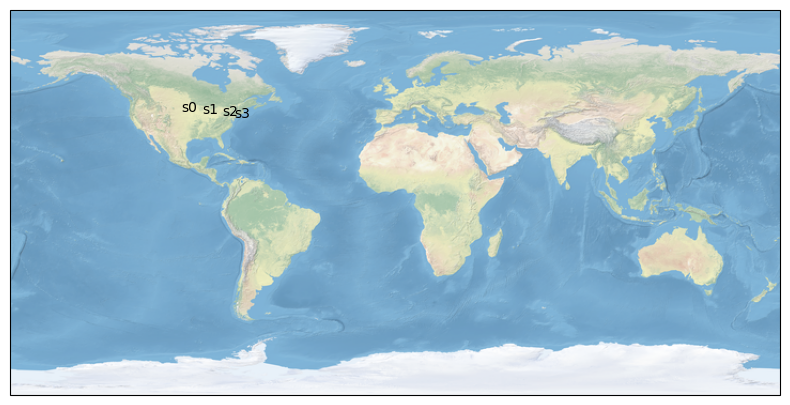

In [6]:
# Map plot, to show the locations on a map
import cartopy as cp
import cartopy.crs as ccrs
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
for i in range(4):
    plt.text(lons[i], lats[i], 's'+str(i))
plt.show()  

### Create a Dataset object in xarray
In the Dataset constructor you have to provide the coordinates, dimensions and variables:
- The coordinates *time, lat, lon* are defined in a dict **coords** as keys
- The variables *temperature, precipitation* are defined in a dict **data_vars** as keys
- The dimensions *time, station* are defined as the first entry of your dict value tuple
- The actual data arrays are provided as the second entry of your dict value tuple

In [16]:
ds = xr.Dataset(data_vars={'temperature': (['station', 'time'],  temp),
                           'precipitation': (['station', 'time'],  precip),},
                coords={'lon': ('station', lons),
                        'lat': ('station', lats),
                        'time': ('time', times),})

#### Overview of the Dataset:
There are two different ways to get an overview of the Dataset object:
- **ds** shows the dimensions, coordinates and data variables including some content
- **ds.info()** provides a ncdump-like result of the meta data header 

In [17]:
ds

<xarray.Dataset>
Dimensions:        (station: 4, time: 365)
Coordinates:
    lon            (station) float64 -99.83 -90.32 -80.79 -75.23
    lat            (station) float64 42.25 41.21 40.63 39.59
  * time           (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31
Dimensions without coordinates: station
Data variables:
    temperature    (station, time) float64 297.5 290.1 297.9 ... 295.6 294.9
    precipitation  (station, time) float64 4.138 4.671 2.737 ... 0.9686 6.713

In [18]:
ds.info()

xarray.Dataset {
dimensions:
	station = 4 ;
	time = 365 ;

variables:
	float64 temperature(station, time) ;
	float64 precipitation(station, time) ;
	float64 lon(station) ;
	float64 lat(station) ;
	datetime64[ns] time(time) ;

// global attributes:
}

#### Access the DataArray objects
To add some meta data to our Dataset object we need to know how to access single variables:

In [19]:
ds['temperature'] # label-based indexing

<xarray.DataArray 'temperature' (station: 4, time: 365)>
array([[297.47403467, 290.11469223, 297.91165415, ..., 297.19792383,
        293.58016892, 295.36026532],
       [293.06436582, 297.60220466, 291.31737527, ..., 290.21018049,
        297.59542697, 294.84841142],
       [295.3584183 , 296.82468791, 292.55693219, ..., 293.87021656,
        296.47599119, 296.67565647],
       [293.95868316, 297.8996341 , 294.45916074, ..., 292.14632154,
        295.62807615, 294.89553759]])
Coordinates:
    lon      (station) float64 -99.83 -90.32 -80.79 -75.23
    lat      (station) float64 42.25 41.21 40.63 39.59
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31
Dimensions without coordinates: station

#### Add Metadata
To make our Dataset CF compliant we need some attributes. This example is not complete, it is only supposed to show you how to add attributes to variables and coordinates. In xarray Datasets this is simply done by adding *.attrs* and assigning the desired attributes in a dict.

In [20]:
ds['temperature'].attrs = {'units': 'K', 'standard_name': 'air_temperature'}
ds['precipitation'].attrs = {'units': 'kg m-2', 'standard_name': 'precipitation_amount'}
ds['lon'].attrs = {'units': 'degrees_east'}
ds['lat'].attrs = {'units': 'degrees_north'}
ds.attrs = {'description': 'monthly precipitation and temperature data at 4 stations in North America', 
            'contact': 'remon.sadikni@uni-hamburg.de', 
            'institution': 'ICDC, CEN, University Hamburg'}

Regarding the time variable, we don't need to provide all attributes because xarray will provide the units and calendar attribute for us. Unfortunately we cannot see that in the output of ds.info() but we will see this later when we look at the real netCDF header of ncdump. 

In [21]:
ds.info()

xarray.Dataset {
dimensions:
	station = 4 ;
	time = 365 ;

variables:
	float64 temperature(station, time) ;
		temperature:units = K ;
		temperature:standard_name = air_temperature ;
	float64 precipitation(station, time) ;
		precipitation:units = kg m-2 ;
		precipitation:standard_name = precipitation_amount ;
	float64 lon(station) ;
		lon:units = degrees_east ;
	float64 lat(station) ;
		lat:units = degrees_north ;
	datetime64[ns] time(time) ;

// global attributes:
	:description = monthly precipitation and temperature data at 4 stations in North America ;
	:contact = remon.sadikni@uni-hamburg.de ;
	:institution = ICDC, CEN, University Hamburg ;
}

___
### Input / Output <a name="input_output"></a>

You can directly write Xarray objects to disk using `to_netcdf()`

#### Write netCDF file
You can write your Dataset to a netCDF by using .to_netcdf(FILENAME):

In [22]:
ds.to_netcdf('random_temp_precip.nc')

#### Checking the content of the netCDF files
Let's have a look at the header of the netCDF file via ncdump:
- there are some additional attributes that we did not set such as the time units

In [23]:
!ncdump -h random_temp_precip.nc


netcdf random_temp_precip {
dimensions:
	station = 4 ;
	time = 365 ;
variables:
	double temperature(station, time) ;
		temperature:_FillValue = NaN ;
		temperature:units = "K" ;
		temperature:standard_name = "air_temperature" ;
		temperature:coordinates = "lat lon" ;
	double precipitation(station, time) ;
		precipitation:_FillValue = NaN ;
		precipitation:units = "kg m-2" ;
		precipitation:standard_name = "precipitation_amount" ;
		precipitation:coordinates = "lat lon" ;
	double lon(station) ;
		lon:_FillValue = NaN ;
		lon:units = "degrees_east" ;
	double lat(station) ;
		lat:_FillValue = NaN ;
		lat:units = "degrees_north" ;
	int64 time(time) ;
		time:units = "days since 2022-01-01 00:00:00" ;
		time:calendar = "proleptic_gregorian" ;

// global attributes:
		:description = "monthly precipitation and temperature data at 4 stations in North America" ;
		:contact = "remon.sadikni@uni-hamburg.de" ;
		:institution = "ICDC, CEN, University Hamburg" ;
}


#### Read netCDF file
Reading in netCDF files in xarray is also simple:

In [24]:
ds = xr.open_dataset('random_temp_precip.nc', decode_times=False) # dont convert relative time steps to absolute ones

In [25]:
ds.info()

xarray.Dataset {
dimensions:
	station = 4 ;
	time = 365 ;

variables:
	float64 temperature(station, time) ;
		temperature:units = K ;
		temperature:standard_name = air_temperature ;
	float64 precipitation(station, time) ;
		precipitation:units = kg m-2 ;
		precipitation:standard_name = precipitation_amount ;
	float64 lon(station) ;
		lon:units = degrees_east ;
	float64 lat(station) ;
		lat:units = degrees_north ;
	int64 time(time) ;
		time:units = days since 2022-01-01 00:00:00 ;
		time:calendar = proleptic_gregorian ;

// global attributes:
	:description = monthly precipitation and temperature data at 4 stations in North America ;
	:contact = remon.sadikni@uni-hamburg.de ;
	:institution = ICDC, CEN, University Hamburg ;
}

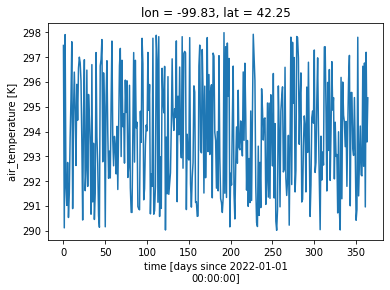

In [26]:
ds["temperature"][0,:].plot() # time series plot of station 0
plt.show()

## How to read in CSV data
If you have data in CSV format you can use Pandas to read them in

In [27]:
!head /data/icdc/atmosphere/dwd_stations/DATA/dwdstation_hamburg_fuhlsbuettel_kl_10147.csv

#Stations-Kennziffer, Stations-ID, Stationsname, Stationshoehe (m), Geogr. Breite, Geogr. Laenge, Jahr, Monat, Tag, Tagesmittel des Luftdruckes in Stationshoehe (hPa), Quality, Tagesmaximum der Temperatur der Luft in 2m Hoehe (grad C), Quality, Tagesminimum der Temperatur der Luft in 2m Hoehe (grad C), Quality, Tagesmittel der Temperatur der Luft in 2m Hoehe (grad C), Quality, Tagesmittel des Dampfdrucks (hPa), Quality, Tagesmittel der relativen Feuchte (%), Quality, Tagesmittel der Windstaerke (Bft), Quality, Tagesmittel des Bedeckungsgrades (achtel), Quality, Tagessumme der Sonnenscheindauer (h), Quality, Tagessumme des Niederschlags (mm/24Std.), Kennung fuer die Art des Niederschlags (24Std.), Quality, Schneehoehe, Art der Schneedecke: (R=2 D=3 F=4), Quality, Tagesmaximum der Windgeschwindigkeit (m/s), Quality, Wasseraequivalent der Gesamtschneedecke SH (mm), Quality
10147, 01459, Hamburg-Fuhlsb�ttel, 11, 53.6332, 9.9881, 1891, 01, 01, -999.9, 9, -7.2, 0, -13.2, 0, -10.7, 0, 2.1, 0,

In [28]:
import pandas as pd
# read in Hamburg Fuhlsbuettel station, Date (6,7,8: day, month, year) and daily mean air temperature (15)
fn='/data/icdc/atmosphere/dwd_stations/DATA/dwdstation_hamburg_fuhlsbuettel_kl_10147.csv'
df=pd.read_csv(fn,encoding = "ISO-8859-1",usecols=[6,7,8,15],parse_dates=[[0,1,2]])
df.columns=['time','airtemp'] # Make column names shorter
df.set_index('time', inplace=True)
df

airtemp
time               
1891-01-01    -10.7
1891-01-02     -7.6
1891-01-03    -10.3
1891-01-04     -1.3
1891-01-05     -4.1
...             ...
2024-07-11     19.6
2024-07-12     18.2
2024-07-13     15.8
2024-07-14     16.7
2024-07-15     19.1

[48774 rows x 1 columns]

In [29]:
ds_from_dataframe = df.to_xarray()
ds_from_dataframe.info()

xarray.Dataset {
dimensions:
	time = 48774 ;

variables:
	datetime64[ns] time(time) ;
	float64 airtemp(time) ;

// global attributes:
}

In [30]:
ds_from_dataframe

<xarray.Dataset>
Dimensions:  (time: 48774)
Coordinates:
  * time     (time) datetime64[ns] 1891-01-01 1891-01-02 ... 2024-07-15
Data variables:
    airtemp  (time) float64 -10.7 -7.6 -10.3 -1.3 -4.1 ... 18.2 15.8 16.7 19.1

## How to read in netCDF data
In our example we have:
- 2 real stations from NOAA: https://coastwatch.pfeg.noaa.gov/erddap/files/erdCinpKfmT/
- parameters: sea water temperature
- we read them in by means of xarray


#### load the single data sets

In [46]:
ds_anacapa1 = xr.open_dataset("../DATA/KFMTemperature_Anacapa_East_Fish_Camp.nc")
ds_anacapa2 = xr.open_dataset("../DATA/KFMTemperature_Anacapa_Black_Sea_Bass_Reef.nc")

In [47]:
ds_anacapa1.info()

xarray.Dataset {
dimensions:
	LON = 1 ;
	LAT = 1 ;
	DEPTH = 1 ;
	TIME = 16733 ;

variables:
	float32 LON(LON) ;
		LON:_CoordinateAxisType = Lon ;
		LON:actual_range = [-119.38333 -119.38333] ;
		LON:axis = X ;
		LON:long_name = Longitude ;
		LON:standard_name = longitude ;
		LON:units = degrees_east ;
	float32 LAT(LAT) ;
		LAT:_CoordinateAxisType = Lat ;
		LAT:actual_range = [34. 34.] ;
		LAT:axis = Y ;
		LAT:long_name = Latitude ;
		LAT:standard_name = latitude ;
		LAT:units = degrees_north ;
	int32 DEPTH(DEPTH) ;
		DEPTH:_CoordinateAxisType = Height ;
		DEPTH:_CoordinateZisPositive = down ;
		DEPTH:actual_range = [11 11] ;
		DEPTH:axis = Z ;
		DEPTH:long_name = Depth ;
		DEPTH:positive = down ;
		DEPTH:standard_name = depth ;
		DEPTH:units = m ;
	datetime64[ns] TIME(TIME) ;
		TIME:_CoordinateAxisType = Time ;
		TIME:actual_range = [1.12629060e+09 1.18652268e+09] ;
		TIME:axis = T ;
		TIME:long_name = Time ;
		TIME:standard_name = time ;
		TIME:time_origin = 01-JAN-1970 00:00:00 ;
	fl

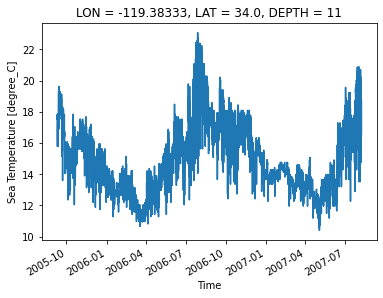

In [48]:
ds_anacapa1["Temperature"].plot()

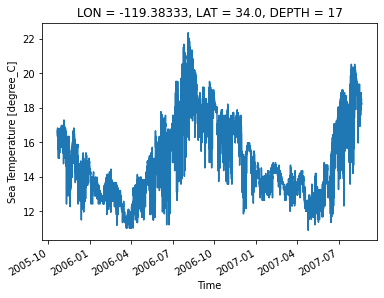

In [49]:
ds_anacapa2["Temperature"].plot()

In [50]:
length1 = ds_anacapa1["Temperature"].size
length2 = ds_anacapa2["Temperature"].size 
print(length1, length2)
print(ds_anacapa1["TIME"].min().values, ds_anacapa1["TIME"].max().values, 
      ds_anacapa2["TIME"].min().values, ds_anacapa1["TIME"].max().values)

16733 16065
2005-09-09T18:30:00.000000000 2007-08-07T21:38:00.000000000 2005-10-20T17:32:00.000000000 2007-08-07T21:38:00.000000000


### Links <a name="exercises_links"></a>
* [Offical Xarray Documentation](http://xarray.pydata.org/en/stable/index.html)
* This was only an introduction to Xarray. There are many more features left to be explored.